In [2]:
from scipy.signal import find_peaks
from ipywidgets import FileUpload
from IPython.display import Audio
import matplotlib.pylab as plt
import soundfile as sf
import pandas as pd
import numpy as np
import tempfile
import librosa
import io  

In [8]:
# Upload audio file (should be .wav type)
upload = FileUpload(accept="audio/*", multiple=False)
display(upload)

FileUpload(value=(), accept='audio/*', description='Upload')

In [13]:
# Content of uploaded file
# It is saved in memory
uploaded_file

{'name': 'M02_LT_z01.wav',
 'type': 'audio/wav',
 'size': 38678,
 'content': <memory at 0x0000021F2848ABC0>,
 'last_modified': datetime.datetime(2024, 3, 28, 9, 27, 13, 410000, tzinfo=datetime.timezone.utc)}

In [14]:
# Getting values from .wav file and saving them in array audio_np
uploaded_file = upload.value[0]
audio_content = uploaded_file['content']
audio_np = np.frombuffer(audio_content, dtype=np.int16)

In [15]:
# Finding sample_rate of audio file
with sf.SoundFile(io.BytesIO(audio_content)) as audio:
    sample_rate = audio.samplerate
sample_rate

11025

In [16]:
# Creating temporary file to listen it later
with tempfile.NamedTemporaryFile(suffix='.wav', delete=False) as tmp_file:
    tmp_filename = tmp_file.name
    sf.write(tmp_filename, audio_np, samplerate=sample_rate)

In [17]:
display(Audio(filename=tmp_filename))

In [18]:
y, sr = librosa.load(tmp_filename, sr=sample_rate)
y_trimmed = y[int(0.01 * sr):]
duration_in_seconds = len(y) / sr
time_in_milliseconds = pd.Series(range(len(y_trimmed))) * (duration_in_seconds / len(y_trimmed)) * 1000
audio_series = pd.Series(y_trimmed, index=time_in_milliseconds)

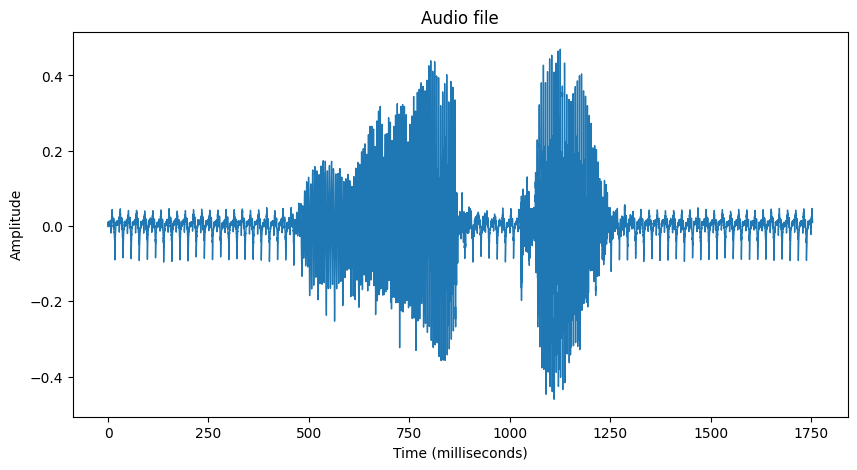

In [19]:
audio_series.plot(figsize=(10, 5), lw=1, title='Audio file')
plt.xlabel('Time (milliseconds)')
plt.ylabel('Amplitude')
plt.show()

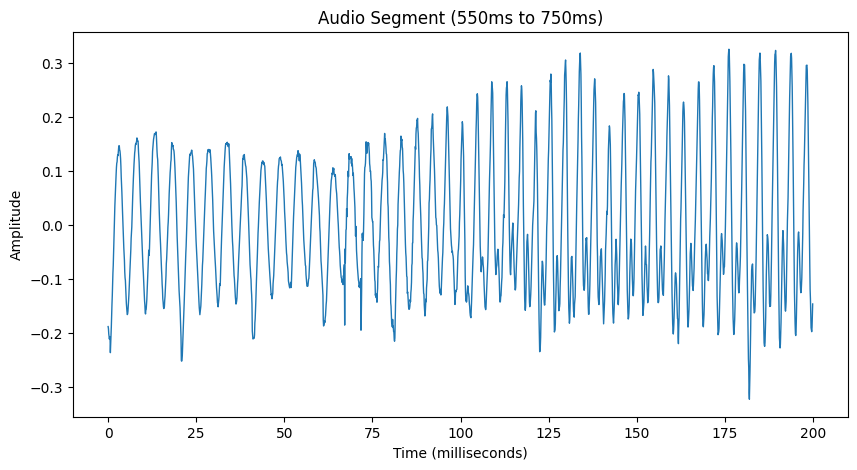

In [20]:
# If audio is too long we can select part of audio by defining start and finish in miliseconds
start_in_miliseconds = 550
end_in_miliseconds = 750

start_sample = int(sr * start_in_miliseconds/1000)
end_sample = int(sr * end_in_miliseconds/1000)

y_segment = y[start_sample:end_sample]
time_in_miliseconds = (pd.Series(range(start_sample, end_sample)) - start_sample) * (1000.0 / sr)
audio_series_segment = pd.Series(y_segment, index=time_in_miliseconds)

audio_series_segment.plot(figsize=(10, 5), lw=1, title=f'Audio Segment ({start_in_miliseconds}ms to {end_in_miliseconds}ms)')
plt.xlabel('Time (milliseconds)')
plt.ylabel('Amplitude')
plt.show()

In [21]:
def autocorrelation(signal):
    result = np.correlate(signal, signal, mode='full')
    return result[result.size // 2:]

In [22]:
# Normalizing the trimmed signal data.
# If we were defining start and finish of segment we should change from y_trimmed to y_segment
data = y_trimmed / np.max(np.abs(y_trimmed))
data

array([-0.0032495 ,  0.00818873,  0.01137324, ...,  0.01865211,
        0.03152011,  0.02391629], dtype=float32)

In [23]:
# Computeing the autocorrelation of the normalized data.
autocorr = autocorrelation(data)
autocorr /= np.max(np.abs(autocorr))

In [24]:
# Finding peaks in the autocorrelation data with a minimum height of 0.5.
peaks, _ = find_peaks(autocorr, height=0.1)

In [25]:
# Determine the fundamental frequency based on the peaks found.
if peaks.size > 0:
    fundamental_period = peaks[0]
    fundamental_freq = sample_rate / fundamental_period
    print(f"The frequency of the tone: {fundamental_freq} Hz")
else:
    print("The frequency of the tone is not find")

The frequency of the tone: 204.16666666666666 Hz


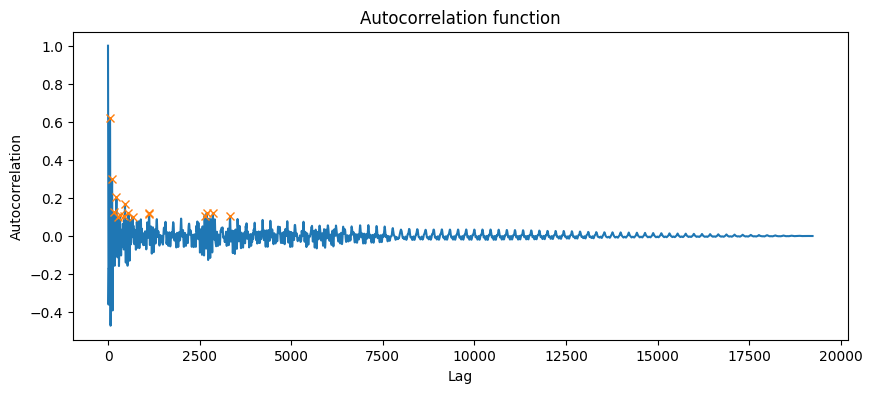

In [26]:
plt.figure(figsize=(10, 4))
plt.plot(autocorr)
plt.plot(peaks, autocorr[peaks], "x")
plt.title('Autocorrelation function')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

In [27]:
# Classifying the detected fundamental frequency into voice categories.

# The average man’s speaking voice, for example, typically has a fundamental frequency between 85 Hz and 155 Hz.
# A woman’s speech range is about 165 Hz to 255 Hz, 
# and a child’s voice typically ranges from 250 Hz to 300 Hz and higher. 
# Author: Alan Lofft
if 85 <= fundamental_freq < 155:
    print("Men")
elif 155 <= fundamental_freq < 165:
    print("Something between men and woman")
elif 165 <= fundamental_freq < 255:
    print("Women")
elif 255 <= fundamental_freq < 300:
    print("Child")
else:
    print("Not vocalized voice")

Women
